# BLIND SOURCE SEPARATION WITH DUET

## Practical Exercise

In this IPython notebook, we will implement DUET algorithm to perform speech source separation.
In particolar, we will learn how to:
    1. import audio and listen to it in python
    2. perform a Short Time Fourier Transform and visualize its results as a Spectrogram
    3. implement a naive version of the DUET algorthim (using only the phase information)
    
### References
- _Rickard, Scott. “The DUET blind source separation algorithm.” Blind Speech Separation. Springer Netherlands, 2007._   
- _Yilmaz, Ozgur, and Scott Rickard. “Blind separation of speech mixtures via time-frequency masking.” Signal Processing, IEEE transactions, 2004._

Let's begin by importing the necessary libraries all of which can be installed with pip

In [4]:
import numpy as np
import matplotlib.pyplot as pl

from scipy.signal import find_peaks
from mir_eval.separation import bss_eval_images

import soundfile as sf  # to load wav audio files
import stft # to perform stft

import IPython

## Some hyperparametes and file system path
Here some paths to the data folder and some hypersparameter.

In this tutorial, we will do some _inform_ our source separation, that is, we use some a-priori knowledge.  
In particular we know how many sound-sources/speaker we want to separate.

In [5]:
# some environmental parameter.
dir_data = "./data/" 
dir_mix = dir_data + "mixtures/"    # path to the mixtures
dir_gt = dir_data + "ground_truth/" # path to the clean sound sources
fig_size = (10, 5)

# analysis parameters
wavefile = "3speech_2chan.wav"  # file to be analysed
n_src = 2 # number of sound sources

tw = 64 # [ms] STFT analysis window - it a typical parameter used in litterature
ov = 50 # [%]  STFT window overlap  - it a typical parameter used in litterature

## Load sound in Python
Let's load the mixture signal, that is the signal recorded at the microphone.  
... and listen to it with '''IPython.display.Audio'''

In [7]:
#### Load the mixture
# TODO.
#  - use the function in wav to import the file wav
#  - check the dimension of the matrix (Samples x Channels)
#  - plot the waveforms (all the channels) as fuction of time [seconds]
#  - use IPython.display.Audio to listen to one channel

mix, fs = sf.read(dir_mix + wavefile)
L, n_chan = mix.shape
print(mix.shape)

print("Mixture at one channel:")
IPython.display.Audio(mix[:,1], rate=fs)

(64000, 2)
Mixture at one channel:


Now that our hears are satisfied, let s plot the signals so that our eyes can enjoy as well

/home/ddicarlo/Documents/Teaching/ISTIC/2020 - Auditory scene analysis/TP/VAI2020_TP_DUET/venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


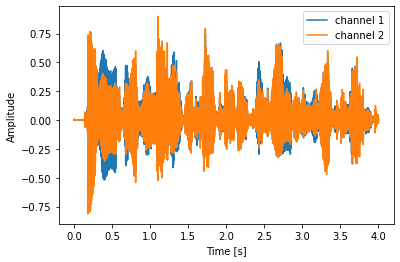

In [8]:
#### Plot the mixture
# TODO.
#  - plot the waveforms (all the channels) as fuction of time [seconds]
#  - change the axis to diplay time information

time_support = np.arange(L)/fs

pl.plot(time_support, mix)
pl.legend(['channel 1', 'channel 2'])
pl.xlabel('Time [s]')
pl.ylabel('Amplitude')
pl.axes().set_aspect('auto')
pl.show()

## STFT reprensentation
Most of the approaches in the litterature work in the Short Time Fourier Transform (STFT) domain.  
DUET does the same. So we need to compute the stft of observed signal.

### Reference
https://en.wikipedia.org/wiki/Short-time_Fourier_transform

1024 512
(513, 124)


/home/ddicarlo/Documents/Teaching/ISTIC/2020 - Auditory scene analysis/TP/VAI2020_TP_DUET/stft.py:134: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sigFrame = sig[frameRange]
/home/ddicarlo/Documents/Teaching/ISTIC/2020 - Auditory scene analysis/TP/VAI2020_TP_DUET/stft.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  framed[sigFrameRange + list(index)] = sigFrame
/home/ddicarlo/Documents/Teaching/ISTIC/2020 - Auditory scene analysis/TP/VAI2020_TP_DUET/stft.py:146: FutureWarning: Using a non-tuple sequence for multidimensional indexi

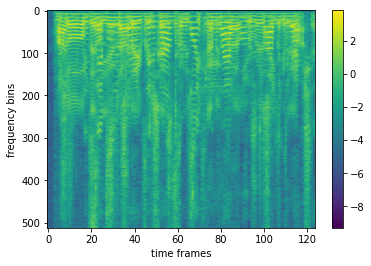

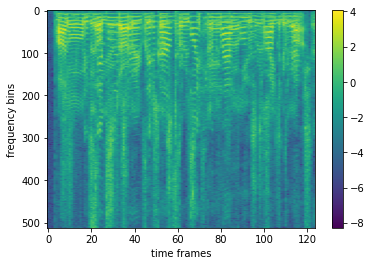

In [9]:
#### Go to STFT domain
# TODO. Use:
#   - stft.stft(signal, fraeSize, hopSize), frameSize in bin, hopSize in bins
#   - display the spectrogram


nfft = int(fs*tw/1000)
hop  = int(nfft*ov/100)
print(nfft, hop)

MIX = stft.stft(mix, nfft, hop)
MIC1 = MIX[:,:,0]
MIC2 = MIX[:,:,1]
print(MIC1.shape)

def plot_spectrogram(x):  
    pl.imshow(np.log(np.abs(x)))
    pl.axes().set_aspect('auto')
    pl.xlabel('time frames')
    pl.ylabel('frequency bins')
    pl.colorbar()
    pl.show()

plot_spectrogram(MIC1)  
plot_spectrogram(MIC2)

/home/ddicarlo/Documents/Teaching/ISTIC/2020 - Auditory scene analysis/TP/VAI2020_TP_DUET/venv/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


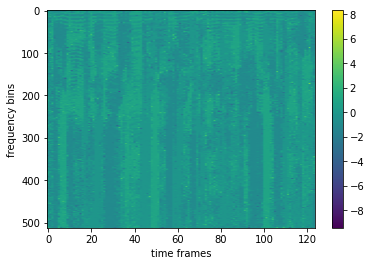

/home/ddicarlo/Documents/Teaching/ISTIC/2020 - Auditory scene analysis/TP/VAI2020_TP_DUET/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


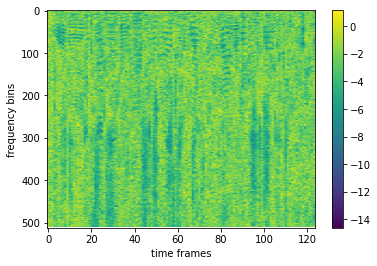

In [13]:
#### Compute log-ratio of spectrograms
# TODO.
R = MIC1/MIC2

# compute the log abs of the ratio.
# this quantity is refered as Interaural Level Difference (ILD)
absR = np.log(np.abs(R))
# and the phase difference, i.e. the angle of the ratio
# which is called Interaural Phase Difference
argR = np.angle(R/np.abs(R))

plot_spectrogram(10**absR)
plot_spectrogram(argR)

# in this tutorial we will use only the ILD
# BONUS: 
#    - extend the turorial in order to use both ILD and IPD, which is
#      what the real DUET algorithm does
#    - you can find the 
R = absR

## BLIND SOURCE SEPARATION WITH DUET

In this part of the tutorial you are going to implement a vanilla version of the DUET algorithm.  
The original algorithm estract both phase and magnitude information and cluster the peaks in a 3D space:  
   (Delays/Phase x Amplitude/Magnitude x Histogram peaks)
Here we are going to use only the magnitude information.

### Bonus exercise
Implement the full DUET algorithm with both phase and magnitude information.

### References

- _Rickard, Scott. “The DUET blind source separation algorithm.” Blind Speech Separation. Springer Netherlands, 2007._
- _Yilmaz, Ozgur, and Scott Rickard. “Blind separation of speech mixtures via time-frequency masking.” Signal Processing, IEEE transactions, 2004._


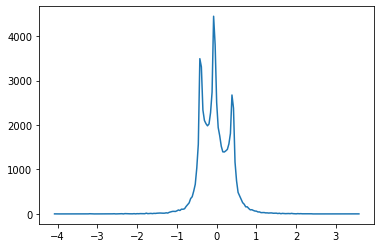

In [14]:
#### 4) Compute histogram of ratios
# TODO. Use:
#   - histcounts
hist, edges = np.histogram(R.flatten(), bins=200)
edges = (edges[1:] + edges[0:-1])/2

pl.plot(edges, hist)
pl.show()

In [15]:
#### 5) Extract peaks of the histogram
# TODO.
(peaks, prop) = find_peaks(hist, threshold = np.max(hist)*0.03)
print(peaks)

[ 95 104 116]


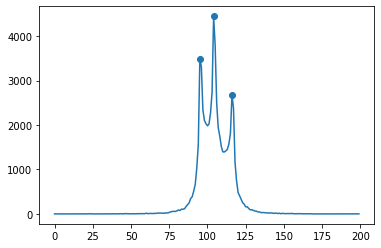

In [16]:
#### 6) Plot histogram and peaks
# TODO.
pl.plot(hist)
pl.scatter(peaks, hist[peaks])
pl.show()

/home/ddicarlo/Documents/Teaching/ISTIC/2020 - Auditory scene analysis/TP/VAI2020_TP_DUET/venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


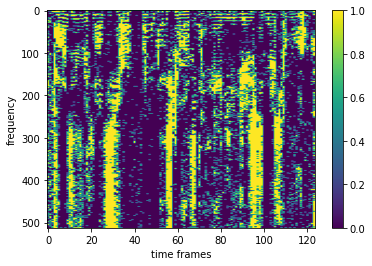

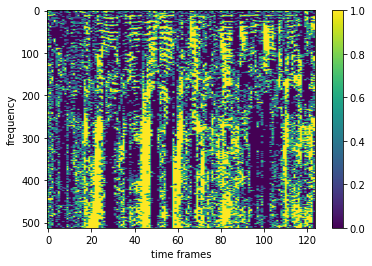

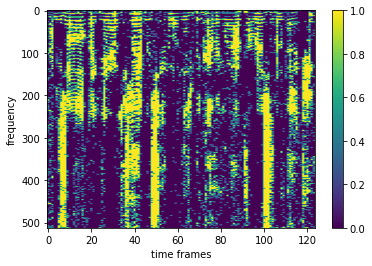

In [17]:
#### 7) Compute Masks
# TODO.
K = np.size(peaks)
F, T = R.shape
mask = np.zeros([F,T,K])
for f in range(F):
    for t in range(T):
        diff = abs(R[f,t] - edges[peaks]);
        nearest_k = np.argmin(diff)
        mask[f,t,nearest_k] = 1;

def plot_mask(x):  
    pl.imshow(x)
    pl.axes().set_aspect('auto')
    pl.xlabel('time frames')
    pl.ylabel('frequency')
    pl.colorbar()
    pl.show()

for k in range(K):
    plot_mask(mask[:,:,k])

In [18]:
#### 8) Apply masks 
# TODO. 
s_est = np.zeros([L,2,K])
for k in range(K):
    s_est[:,0,k] = stft.istft(MIC1*mask[:,:,k], 1, hop)
    s_est[:,1,k] = stft.istft(MIC2*mask[:,:,k], 1, hop)

/home/ddicarlo/Documents/Teaching/ISTIC/2020 - Auditory scene analysis/TP/VAI2020_TP_DUET/stft.py:235: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  S *= win[[Ellipsis] + [None] * (len(S.shape) - len(win.shape))]
/home/ddicarlo/Documents/Teaching/ISTIC/2020 - Auditory scene analysis/TP/VAI2020_TP_DUET/stft.py:252: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  frameSig = S[[Ellipsis] + list(index)]
/home/ddicarlo/Documents/Teaching/ISTIC/2020 - Auditory scene analysis/TP/VAI2020_TP_DUET/stft.py:253: FutureWarning: Using a non-tuple sequenc

In [19]:
#### 9) Save sounds
# TODO. Use:
#  - istft
#  - audiowrite
for k in range(K):
    output_name = wavefile[:-4] + "_res" + str(k) + ".wav"
    wav.wavwrite(s_est[:,:,k], fs, output_name)

File written to 3speech_2chan_res0.wav
File written to 3speech_2chan_res1.wav
File written to 3speech_2chan_res2.wav


## EVALUATION
Now it is time to evaluate our separation. It is common to use the MBSS_EVAL metrics (see References below).  
Sound Mixture have:
- target _sources_ of interests
- _interferences_ (cross-talk)
- _noise_ (reverberation or measuremets)  
moreover, our algo can add spurious sounds, we call these sounds _artifacs_.

This (originally matlab) toolboIx aim to quantify this _error_ with the following metrics:
- SIR: Signal to Intereference ratio (estimated source vs. non-origin sources)
- SAR: Signal to Artifact ratio (estimated source vs. artifacts)
- SNR: Signal to Noise ratio    (estimated source vs. origin source)
- SDR: Signal to Distortion ratio: an accumulating general metrics
- (ISR: Image to Spatial Distortion ratios)

In python we can use the module mir_eval (Music Information Retrieval evaluation). We just need to input our prediction and the ground-truth.

### References
- _http://craffel.github.io/mir_eval/ _
- _http://bass-db.gforge.inria.fr/bss_eval/: A toolbox for performance measurement in (blind) source separation_
- _E. Vincent, R. Gribonval and C. Févotte, Performance measurement in blind audio source separation, IEEE Trans. Audio, Speech and Language Processing, 14(4), pp 1462-1469, 2006._

['./data/ground_truth/3speech_2chan_gt1.wav', './data/ground_truth/3speech_2chan_gt2.wav', './data/ground_truth/3speech_2chan_gt3.wav']


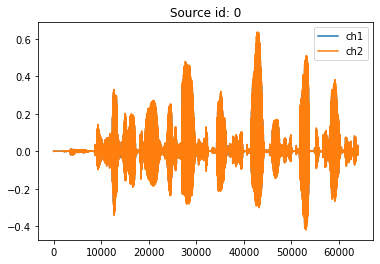

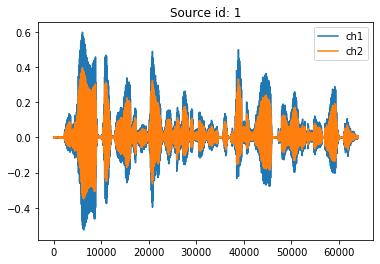

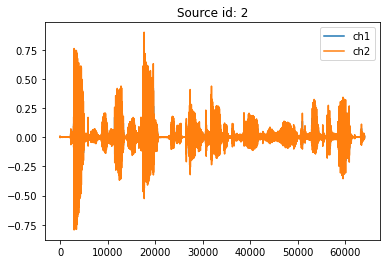

In [20]:
#### 10) Evaluate method. Compare to: Mix, Oracle Masks.
# TODO. Use:
#  - bss_eval_images
#  - ground_truth sounds
dir = "./data/ground_truth/"
files = [dir + wavefile[:-4] + "_gt" + str(k+1) + ".wav" for k in range(K)]
print(files)

for i, f in enumerate(files):
    ref_src, _ = wav.wavread(f)

    pl.plot(ref_src)
    pl.title("Source id: " + str(i) )
    pl.legend(["ch1", "ch2"])
    pl.show()
    
    if i > 0:
        ref_srcs = np.dstack([ref_srcs, ref_src])
    else:
        ref_srcs = ref_src
        
est_srcs = s_est

ref_srcs = np.transpose(ref_srcs, (1,0,2))
est_srcs = np.transpose(est_srcs, (1,0,2))

In [21]:
#### 10) Evaluate method:
# TODO. Use:
#  - create two matrix Channel x Samples x Images, one stacking the gt sources, the other staking
#    estimated sounds
#  - bss_eval_images in mir_eval module

(sdr, isr, sir, sar, perm) = bss_eval_images(ref_srcs, est_srcs)

print('sdr', sdr)
print('isr', isr)
print('sir', sir)
print('sar', sar)
print('perm', perm)

sdr [-2.9925723  -2.61831745]
isr [-2.83686436 -2.47993868]
sir [27.44126178 27.42752606]
sar [11.59262959 11.66117651]
perm [1 0]
